# Lab 4 : Iterative phase estimation

In this lab, you'll implement a simple version of the iterative phase estimation algorithm. Using the recently introduced dynamic circuits capabilities, you'll be able to run the algorithm on an IBM quantum processor! This lab was adapted from the IBM Quantum Spring Challenge 2023, so if you participated in that challenge, it may look familiar. To encourage you to review the lab nevertheless, we added an extra exercise at the end.

## Background

The quantum phase estimation (QPE) algorithm is one of the most important and famous quantum algorithms. It is a key subroutine of Shor's factoring algorithm, as well as algorithms for quantum simulation. The textbook version of the algorithm uses a number of auxiliary qubits which scales with the desired precision, leading to circuits that are challenging to execute on today's noisy devices with limited qubit number and connectivity.

Iterative phase estimation (IPE) is a variant of QPE which requires only one auxiliary qubit. In IPE, the auxiliary qubit is repeatedly measured, with the measurement results used to guide future quantum operations. Such classical feed-forward was previously impossible to execute on IBM's quantum processors, but with the recently introduced dynamic circuits capabilities, it is now possible.

Like any phase estimation algorithm, IPE is designed to solve the following problem:

**Problem statement:** Given a unitary matrix $U$ and an eigenstate $|\Psi\rangle$ of $U$ with an unknown eigenvalue $e^{i 2\pi \varphi}$, estimate the value of $\varphi$.

A few important details need to be clarified in this problem statement, namely, how $U$ and $|\Psi\rangle$ are specified. We assume that $U$ is given as a quantum circuit implementing $U$, and in fact, we assume we have the ability to efficiently implement the operations *controlled*-$U^{2^t}$ for positive integers $t$.
This is the same assumption used in the original QPE algorithm.
The eigenstate is also given as a quantum circuit: we assume we have the ability to efficiently prepare $|\Psi\rangle$.

Let's first assume for simplicity that $\varphi$ can have an exact binary expansion, that is, it can be written as
$$
\varphi = \varphi_1/2 + \varphi_2/4 + \cdots + \varphi_m/2^m = 0.\varphi_1 \varphi_2 \cdots \varphi_m
$$
where in the final equality we are using "decimal" point notation in base 2.
For simplicity, suppose $U$ is a unitary operator acting on one qubit (everything we say here also applies to the case where $U$ acts on multiple qubits). Since IPE requires an auxiliary qubit, we need a system of two qubits, $q_0$ and $q_1$, where $q_0$ is the auxiliary qubit and $q_1$ represents the physical system on which $U$ operates.

Now, suppose that we initialize $q_0$ in the state $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$ and $q_1$ in the state $|\Psi \rangle$.
What happens if we apply the *controlled*-$U^{2^t}$ gate, with $q_0$ being the control and $q_1$ being the target?
Since $|\Psi \rangle$ is an eigenstate of $U$ with eigenvalue $e^{i 2\pi \varphi}$, we have
$$
\begin{align}
|+\rangle |\Psi \rangle &= \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) |\Psi \rangle \\
&= \frac{|0\rangle |\Psi \rangle + |1\rangle |\Psi \rangle}{\sqrt{2}} \\
&\xrightarrow{\text{controlled-}U^{2^t}} \frac{|0\rangle |\Psi \rangle + e^{i 2 \pi 2^{t} \varphi} |1\rangle |\Psi \rangle}{\sqrt{2}} \\
&= \left(\frac{|0\rangle  + e^{i 2 \pi 2^{t} \varphi} |1\rangle}{\sqrt{2}}\right) |\Psi \rangle.
\end{align}
$$
That is, the state of the system qubit remains unchanged, while a phase of $e^{i 2 \pi 2^{t} \varphi}$ has been "kicked back" into the state of the auxiliary qubit.

Now, note that
$$
e^{i 2 \pi 2^{t} \varphi} = e^{i 2 \pi 2^{t} (0.\varphi_1 \varphi_2 \cdots \varphi_m)}
= e^{i 2 \pi (\varphi_1 \cdots \varphi_t . \varphi_{t + 1} \cdots \varphi_m)}
= e^{i 2 \pi (0. \varphi_{t + 1} \cdots \varphi_m)},
$$
where in the last equality, the whole number part of the "decimal" representation of the phase has disappeared because $e^{i 2\pi n} = 1$ for any integer $n$.
For example:
- for $t=0$, the phase would be $e^{i 2 \pi 2^{0} \varphi} = e^{i 2 \pi \varphi} = e^{i 2 \pi 0.\varphi_1 \varphi_2 ... \varphi_m}$
- for $t=1$, the phase would be $e^{i 2 \pi 2^{1} \varphi}= e^{i 2 \pi \varphi_1} e^{i 2 \pi 0.\varphi_2 \varphi_3 ... \varphi_m} = e^{i 2 \pi 0.\varphi_2 \varphi_3 ... \varphi_m}$
- for $t=2$, the phase would be $e^{i 2 \pi 2^{2} \varphi} = e^{i 2 \pi 0.\varphi_3 \varphi_4 ... \varphi_m}$
- for $t=m-1$, the phase would be $e^{i 2 \pi 2^{m-1} \varphi} = e^{i 2 \pi 0.\varphi_m}$.

In the last case where $t = m - 1$, the phase is $e^{i 2 \pi 0.\varphi_m}$, which is equal to $1$ if $\varphi_m = 0$ and $-1$ if $\varphi_m = 1$.
In the first case, the auxiliary qubit $q_0$ would be in the state $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$, and in the second case it would be
in the state $|-\rangle = \frac{|0\rangle - |1\rangle}{\sqrt{2}}$. Therefore, measuring the qubit in the Pauli $X$ basis would distinguish these cases with a 100\% success rate.
This is done by performing a Hadamard gate on the qubit before measuring it. In the first case we would measure 0 and in the second case we would measure 1;
in other words, the measured bit would be equal to $\varphi_m$.

### The algorithm

In the first step of the IPE algorithm, we directly measure the least significant bit of the phase $\varphi$, $\varphi_m$, by initializing the 2-qubit registers as described above ( $q_0 \rightarrow |+\rangle$ and $q_1 \rightarrow |\Psi \rangle$ ), performing a *controlled*-$U^{2^{m-1}}$ operation, and measuring $q_0$ in the Pauli $X$ basis.

in the second step, we initialize the systems in the same way and apply a *controlled*-$U^{2^{m-2}}$ operation. The relative phase in $q_0$ after these operations is now $e^{i 2 \pi 0.\varphi_{m-1}\varphi_{m}}= e^{i 2 \pi 0.\varphi_{m-1}} e^{i 2 \pi \varphi_m/4}$. 
To extract the phase bit $\varphi_{m-1}$, first perform a phase correction by rotating around the $Z$-axis by an angle $-2 \pi \varphi_m/4=-\pi \varphi_m/2$, which results in the state of  $q_0$ to be $|0\rangle + e^{i 2 \pi 0.\varphi_{m-1}} | 1 \rangle$. Perform a measurement on $q_0$ in the Pauli $X$ basis to obtain the phase bit $\varphi_{m-1}$. 

Therefore, the $k$-th step of the IPE, getting $\varphi_{m-k+1}$, consists of the register initialization ($q_0$ in $|+\rangle$, $q_1$ in $|\Psi\rangle$), the application of a *controlled*-$U^{2^{m-k}}$, a rotation around $Z$ of angle $\omega_k = -2 \pi 0.0\varphi_{m-k+2} ... \varphi_m$, and a measurement of $q_0$ in the Pauli $X$ basis: a Hadamard transform to $q_0$, and a measurement of $q_0$ in the computational basis. Note that $q_1$ remains in the state $|\Psi\rangle$ throughout the algorithm.

## Implementation

In this lab, we will perform IPE on the single-qubit $S$-gate. The $S$ gate is given by the matrix

$$ S =
\begin{pmatrix}
1 & 0\\
0 & e^{i\pi / 2}
\end{pmatrix}$$

We will use the eigenstate $|\Psi\rangle = |1\rangle$, which has eigenvalue $e^{i\pi / 2}= e^{i2\pi \cdot 1/4}$. So we have $\varphi = 1/4 = 0.01 = 0.\varphi_1 \varphi_2$. Since $\varphi$ can be represented exactly with 2 bits, our quantum circuit implementation will use a classical register with two bits to store the result.

The controlled-$S$ gate can be implemented using the controlled phase gate, available in Qiskit as `CPhaseGate`, which can also be applied by calling the `cp` method of a `QuantumCircuit`. The controlled phase gate is parameterized by an angle $\theta$ and has the matrix
$$
        \text{CPhase}(\theta) =
            \begin{pmatrix}
                1 & 0 & 0 & 0 \\
                0 & 1 & 0 & 0 \\
                0 & 0 & 1 & 0 \\
                0 & 0 & 0 & e^{i\theta}
            \end{pmatrix}
$$


### Step 1

In the first step of the algorithm, we measure the least significant bit of $\varphi$.

#### Exercise 1

Obtain the least significant bit of $\varphi$ by performing the following steps:
1. Initialize the qubits:
   - Apply a Hadamard on the auxiliary qubit.
   - Apply an X gate on the system qubit to put it in the $|1\rangle$ state.
2. Apply a *controlled*-$S^{2}$ gate by applying a `CPhaseGate` with the appropriate angle.
3. Measure the auxiliary qubit in the $X$ basis:
   - Apply a Hadamard gate on the auxiliary qubit.
   - Measure it in the computational basis.

The resulting circuit should look something like this:

![step1-circuit](resources/step1-circuit.png)

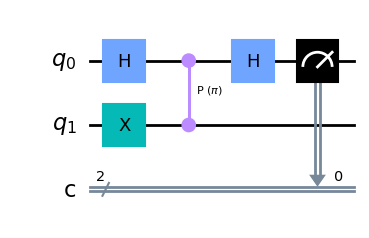

In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def step_1_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    ########## your code goes here #######

    ##1 Initialization

    q0, q1 = qr
    # apply Hadamard on the auxiliary qubit
    qc.h(q0)
    # put the system qubit into the |1> state
    qc.x(q1)

    ##2 Apply control-U operator as many times as needed to get the least significant phase bit

    # controlled-S is equivalent to CPhase with angle pi / 2
    s_angle = np.pi / 2
    # we want to apply controlled-S 2^k times
    k = 1
    # calculate the angle of CPhase corresponding to 2^k applications of controlled-S
    cphase_angle = s_angle * 2**k
    # apply the controlled phase gate
    qc.cp(cphase_angle, q0, q1)

    ##3 Measure the auxiliary qubit in x-basis into the first classical bit

    # apply Hadamard to change to the X basis
    qc.h(q0)
    # measure the auxiliary qubit into the first classical bit
    c0, _ = cr
    qc.measure(q0, c0)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = step_1_circuit(qr, cr)
qc.draw("mpl")

In [2]:
# Submit your circuit

from qc_grader.challenges.qgss_2023 import grade_lab4_ex1

grade_lab4_ex1(qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Step 2

In the first step, we measured the least significant bit $\varphi_2$. In the second (and final) step, we extract the next bit $\varphi_1$, which will involve applying a phase correction to cancel out the phase contribution from $\varphi_2$. The phase correction depends on the value of the classical register holding $\varphi_2$. We need dynamic circuits to perform this classical feedback! The phase correction can be applied using `PhaseGate` or by directly calling the `p` method of a QuantumCircuit.

#### Exercise 2

In this exercise, we begin with the circuit from Step 1, which you should have constructed in Exercise 1.

Obtain the next bit of $\varphi$ by performing the following steps:
1. Reset and re-initialize the auxiliary qubit.
2. Apply the controlled unitary gate.
3. Measure the auxiliary qubit in the $X$ basis.

Here and in the rest of the lab, please use the [`QuantumCircuit.if_else`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.if_else.html) method to apply operations controlled on classical measurement results.

The resulting circuit should look something like the one in the drawing below. Note that in the drawing, the instructions inside the `if_else` instruction are not shown. Therefore, even if your circuit looks the same as the drawing, it may still be different.

![step1-circuit](resources/step2-circuit.png)

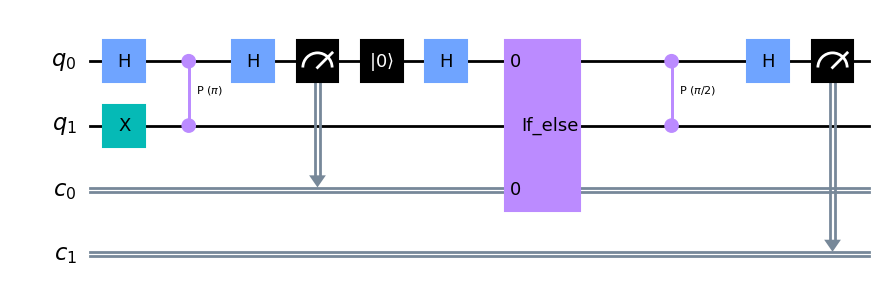

In [3]:
def step_2_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    # begin with the circuit from Step 1
    qc = step_1_circuit(qr, cr)

    ########## your code goes here #######

    ##1 Reset and re-initialize the auxiliary qubit

    q0, q1 = qr
    # reset the auxiliary qubit
    qc.reset(q0)
    # apply Hadamard on the auxiiliary qubit
    qc.h(q0)

    ##2 Apply phase correction conditioned on the first classical bit

    c0, c1 = cr
    with qc.if_test((c0, 1)):
        qc.p(-np.pi / 2, q0)

    ##3 Apply control-U operator as many times as needed to get the next phase bit

    # controlled-S is equivalent to CPhase with angle pi / 2
    s_angle = np.pi / 2
    # we want to apply controlled-S 2^k times
    k = 0
    # calculate the angle of CPhase corresponding to 2^k applications of controlled-S
    cphase_angle = s_angle * 2**k
    # apply the controlled phase gate
    qc.cp(cphase_angle, q0, q1)

    ##4 Measure the auxiliary qubit in x-basis into the second classical bit

    # apply Hadamard to change to the X basis
    qc.h(q0)
    # measure the auxiliary qubit into the first classical bit
    qc.measure(q0, c1)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = step_2_circuit(qr, cr)
qc.draw("mpl")

In [4]:
# Submit your circuit

from qc_grader.challenges.qgss_2023 import grade_lab4_ex2

grade_lab4_ex2(qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Run on simulator

Now that we have the complete circuit, let's first run it on a local simulator.

In [5]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
counts

{'01': 1000}

If your circuit is correct, you should have gotten the bitstring `01` with 100% probability. This value corresponds to the phase written in binary as $\varphi = 0.01 = 1/4$. Indeed, this is the correct phase!

### Exercise 3

Construct an IPE circuit to estimate the phase of the T gate, whose matrix is given by

$$ T =
\begin{pmatrix}
1 & 0\\
0 & e^{i\pi / 4}
\end{pmatrix}$$

How many bits are needed to represent the phase in this case?

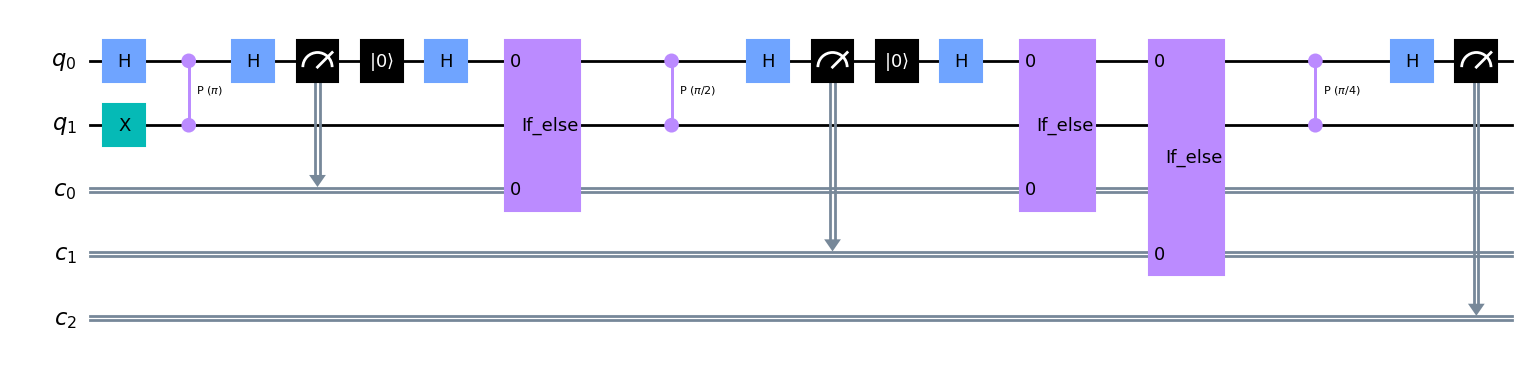

In [6]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def t_gate_ipe_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 3 bits

    qc = QuantumCircuit(qr, cr)

    ########## your code goes here #######

    # Initialization
    q0, q1 = qr
    qc.h(q0)
    qc.x(q1)

    # Apply control-U operator as many times as needed to get the least significant phase bit
    t_angle = np.pi / 4
    k = 2
    cphase_angle = t_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis into the first classical bit
    qc.h(q0)
    c0, c1, c2 = cr
    qc.measure(q0, c0)

    # Reset and re-initialize the auxiliary qubit
    qc.reset(q0)
    qc.h(q0)

    # Apply phase correction conditioned on the first classical bit
    with qc.if_test((c0, 1)):
        qc.p(-np.pi / 2, q0)

    # Apply control-U operator as many times as needed to get the next phase bit
    k = 1
    cphase_angle = t_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis into the second classical bit
    qc.h(q0)
    qc.measure(q0, c1)

    # Reset and re-initialize the auxiliary qubit
    qc.reset(q0)
    qc.h(q0)

    # Apply phase correction conditioned on the first and second classical bits
    with qc.if_test((c0, 1)):
        qc.p(-np.pi / 4, q0)
    with qc.if_test((c1, 1)):
        qc.p(-np.pi / 2, q0)

    # Apply control-U operator as many times as needed to get the next phase bit
    k = 0
    cphase_angle = t_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis into the third classical bit
    qc.h(q0)
    qc.measure(q0, c2)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(3, "c")
qc = QuantumCircuit(qr, cr)
qc = t_gate_ipe_circuit(qr, cr)
qc.draw("mpl")

In [7]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
counts

{'001': 1000}

In [8]:
# Submit your circuit

from qc_grader.challenges.qgss_2023 import grade_lab4_ex3

grade_lab4_ex3(qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### When the phase does not have an exact binary expansion

Let's consider the case when the phase does not have an exact binary expansion, for example, $\varphi = 1/3$.
In this case, the single-qubit gate has the unitary

$$ U =
\begin{pmatrix}
1 & 0\\
0 & e^{i2\pi / 3}
\end{pmatrix}
$$

The angle $\varphi = 1/3$ does not have an exact finite binary expansion. In contrast, it has the infinite binary expansion

$$
1/3 = 0.010101\ldots
$$

In practice we work with a fixed number of bits of precision, so our goal is to obtain the closest value that can be represented with those bits. In the following example, we will use two bits of precision. In this case, the closest value is $0.01 = 1/4$. Because this value does not represent the exact phase, there is some probability that we will obtain a different, less precise result.

In the following code cells, we construct and simulate an IPE circuit to measure the phase of this gate.

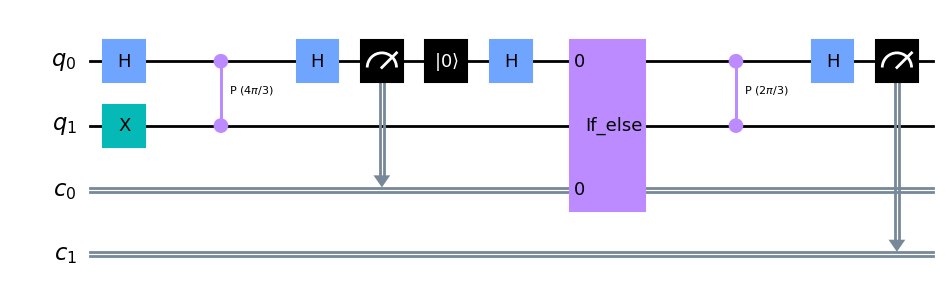

In [9]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    # Initialization
    q0, q1 = qr
    qc.h(q0)
    qc.x(q1)

    # Apply control-U operator as many times as needed to get the least significant phase bit
    u_angle = 2 * np.pi / 3
    k = 1
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis into the first classical bit
    qc.h(q0)
    c0, c1 = cr
    qc.measure(q0, c0)

    # Reset and re-initialize the auxiliary qubit
    qc.reset(q0)
    qc.h(q0)

    # Apply phase correction conditioned on the first classical bit
    with qc.if_test((c0, 1)):
        qc.p(-np.pi / 2, q0)

    # Apply control-U operator as many times as needed to get the next phase bit
    k = 0
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis into the second classical bit
    qc.h(q0)
    qc.measure(q0, c1)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = u_circuit(qr, cr)
qc.draw("mpl")

In [10]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
print(counts)
success_probability = counts["01"] / counts.shots()
print(f"Success probability: {success_probability}")

{'11': 59, '00': 59, '10': 187, '01': 695}
Success probability: 0.695


As you can see, this time, we are not guaranteed to obtain the desired result. A natural question to ask is: How can we boost the success probability?

One way that the algorithm fails is that the first measured bit is incorrect. In this case, the phase correction applied before measuring the second bit is also incorrect, causing the rest of the bits to be likely incorrect as well. A simple way to mitigate this problem is to repeat the measurement of the first few bits several times and take a majority vote to increase the likelihood that we measure the bit correctly. Implementing this procedure within a single circuit requires performing arithmetic on the measured outcomes. Due to a temporary limitation in Qiskit, it is currently not possible to perform arithmetic on measured bits and condition future circuit operations on the results. So, here we will measure each bit using separate circuits.

The following code cells construct and simulate an IPE circuit for measuring just the first bit of the phase.

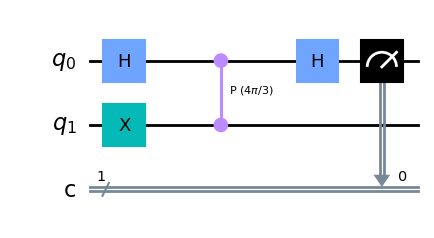

In [11]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 1 bits

    qc = QuantumCircuit(qr, cr)

    # Initialization
    q0, q1 = qr
    qc.h(q0)
    qc.x(q1)

    # Apply control-U operator as many times as needed to get the least significant phase bit
    u_angle = 2 * np.pi / 3
    k = 1
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis
    qc.h(q0)
    (c0,) = cr
    qc.measure(q0, c0)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
qc = u_circuit(qr, cr)
qc.draw("mpl")

In [12]:
job = sim.run(qc, shots=15)
result = job.result()
counts = result.get_counts()
print(counts)

{'0': 2, '1': 13}


Hopefully, the correct bit was measured more often than not.

### Exercise 4

Examine the counts dictionary from the output of the last code cell. What is the correct value for the first bit? Was it measured more often than not? If not, rerun the last code cell until it is. Then, write some code in the code cell below that sets the variable `step1_bit` equal to the value of the bit that was measured the majority of the time.

In [13]:
step1_bit = 1

####### your code goes here #######

print(step1_bit)

1


In [14]:
# Submit your result

from qc_grader.challenges.qgss_2023 import grade_lab4_ex4

grade_lab4_ex4(step1_bit)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Exercise 5

Now construct the circuit to measure the second bit of the phase. Replace the first stage of the circuit with one which simply sets the auxiliary bit to the value we measured above, so that we always measure the correct value for the first bit of the phase.

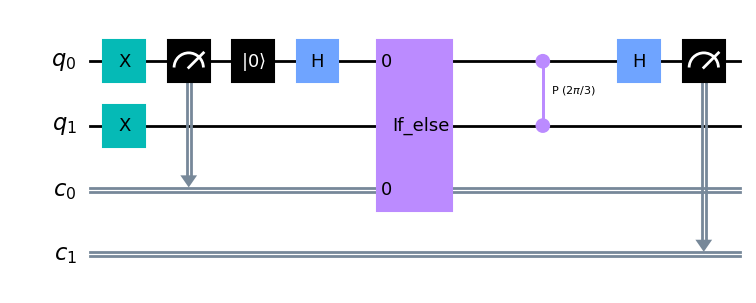

In [15]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    ########## your code goes here #######

    # Initialization
    q0, q1 = qr
    if step1_bit:
        qc.x(q0)
    qc.x(q1)

    # Measure the auxiliary qubit
    c0, c1 = cr
    qc.measure(q0, c0)

    # Reset and re-initialize the auxiliary qubit
    qc.reset(q0)
    qc.h(q0)

    # Apply phase correction conditioned on the first classical bit
    with qc.if_test((c0, 1)):
        qc.p(-np.pi / 2, q0)

    # Apply control-U operator as many times as needed to get the next phase bit
    u_angle = 2 * np.pi / 3
    k = 0
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis into the second classical bit
    qc.h(q0)
    qc.measure(q0, c1)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = u_circuit(qr, cr)
qc.draw("mpl")

In [16]:
# Submit your result

from qc_grader.challenges.qgss_2023 import grade_lab4_ex5

grade_lab4_ex5(qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [17]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
print(counts)
success_probability = counts["01"] / counts.shots()
print(f"Success probability: {success_probability}")

{'11': 72, '01': 928}
Success probability: 0.928


Now, the success probability is much higher than before!

### Exercise 6 (ungraded)

So far, the IPE circuits we constructed were designed for a specific gate and a specific number of bits of precision. Let's now generalize your code to implement a general IPE routine that can handle different gates and levels of precision.

Complete the following function to implement a generalized IPE routine. It takes the following inputs:
- `qr`: The quantum register. The first qubit is assumed to be the auxiliary qubit, and the rest of them the system qubits.
- `cr`: The classical register. Its length indicates the desired number of bits of precision.
- `controlled_unitaries`: A list of gates implementing *controlled*-$U^{2^t}$ for $t = 0, \ldots, m-1$, where $m$ is the number of bits of precision.
- `state_prep`: A gate used to initialize the state of the system qubits.

In [18]:
# import the Gate from the IBM's Qiskit Circuit module
from qiskit.circuit import Gate


# define the function to generate the dynamic quantum circuit
# for a general Iterative Phase Estimation (IPE)
def iterative_phase_estimation(
    qr: QuantumRegister,
    cr: ClassicalRegister,
    controlled_unitaries: list[Gate],
    state_prep: Gate,
) -> QuantumCircuit:
    qc = QuantumCircuit(qr, cr)

    
    ####### your code goes here #######
    
    # retrieve the number of the Controlled-U gates
    m = len( controlled_unitaries )
    
    
    # create a copy of the list of the Controlled-U gates
    controlled_unitaries_reversed = controlled_unitaries.copy()

    # retrieve the reverse list of the Controlled-U gates
    controlled_unitaries_reversed.reverse()
    
    
    # apply the Hadamard gate to the 1st qubit (system's qubit)
    qc.h(0)
    
    
    # initialize the preparation of the state
    # with the eigenstate |1>
    qc.append( state_prep, [1] )
    
    
    # apply the Controlled-U gate for t = (m - 1)
    qc.append( controlled_unitaries_reversed[0], [0, 1] )
    
    
    # apply the Hadamard gate to the 1st qubit (system's qubit)
    qc.h(0)
    
    
    # measure the state of the 1st qubit (system's qubit),
    # storing the classical outcome on the 1st bit
    qc.measure(0, 0)
   

    # for the remaining (m - 1) iterations
    for k in range(1, m):
    
        # reset the state of the 1st qubit (system's qubit)
        qc.reset(0)

        
        # apply the Hadamard gate to the 1st qubit (system's qubit)
        qc.h(0)

        
        # if the 1st bit of the classical register of
        # the dynamic quantum circuit has the classical state 1
        with qc.if_test( ( cr[0], 1 ) ):
            
            # apply the phase correction to the 1st qubit of
            # the quantum register with a P gate
            qc.p( -controlled_unitaries[ ( m - k - 1 ) ].params[0], 0 )

        
        # apply the Controlled-U gate for t = (m - k)
        qc.append( controlled_unitaries_reversed[k], [0, 1] )

        
        # apply the Hadamard gate to the 1st qubit (system's qubit)
        qc.h(0)

        
        # measure the state of the 1st qubit (system's qubit),
        # storing the classical outcome on the kth bit
        qc.measure(0, k)

    
    # return the dynamic quantum circuit
    # for a general Iterative Phase Estimation (IPE)
    return qc

The example below shows how one would use this function to generate the IPE circuit for the Z gate.

In [19]:
# import the Controlled-Phase and Pauli-X gates
# from the IBM's Qiskit Circuit Library module
from qiskit.circuit.library import CPhaseGate, XGate


# create the quantum register with two qubits
# for the quantum circuit to implement IPE on the Z gate
qr = QuantumRegister(2, "q")

# create the quantum register with three bits
# for the quantum circuit to implement IPE on the Z gate
cr = ClassicalRegister(1, "c")


# define the theta angle for the Z gate
z_angle = np.pi


# create the list of Controlled-U/Controlled-Phases gates,
# considering the theta angle for the Z gate
controlled_unitaries = [ CPhaseGate( z_angle * 2**k ) for k in range(1) ]


# generate the quantum circuit implementing
# the IPE for the Z gate
qc = iterative_phase_estimation( qr, cr, controlled_unitaries, XGate() )


# draw the quantum circuit implementing
# the IPE for the Z gate
qc.draw("mpl")


# create an Aer Simulator object
sim = AerSimulator()


# create a job for the quantum circuit implementing
# the IPE for the Z gate, running the Aer Simulator
job = sim.run(qc, shots=1000)


# retrieve the result counts of the quantum simulation
result = job.result()

# retrieve the result counts of the quantum simulation
counts = result.get_counts()


# show the result counts of the quantum simulation
counts

{'1': 1000}

The example below shows how one would use this function to generate the IPE circuit for the $S$ gate. The simulation results should match what you got above.

In [20]:
# import the Controlled-Phase and Pauli-X gates
# from the IBM's Qiskit Circuit Library module
from qiskit.circuit.library import CPhaseGate, XGate


# create the quantum register with two qubits
# for the quantum circuit to implement IPE on the S gate
qr = QuantumRegister(2, "q")

# create the quantum register with three bits
# for the quantum circuit to implement IPE on the S gate
cr = ClassicalRegister(2, "c")


# define the theta angle for the S gate
s_angle = np.pi / 2


# create the list of Controlled-U/Controlled-Phase gates,
# considering the theta angle for the S gate
controlled_unitaries = [ CPhaseGate( s_angle * 2**k ) for k in range(2) ]


# generate the quantum circuit implementing
# the IPE for the S gate
qc = iterative_phase_estimation( qr, cr, controlled_unitaries, XGate() )


# draw the quantum circuit implementing
# the IPE for the S gate
qc.draw("mpl")


# create an Aer Simulator object
sim = AerSimulator()


# create a job for the quantum circuit implementing
# the IPE for the S gate, running the Aer Simulator
job = sim.run(qc, shots=1000)


# retrieve the result counts of the quantum simulation
result = job.result()

# retrieve the result counts of the quantum simulation
counts = result.get_counts()


# show the result counts of the quantum simulation
counts

{'01': 1000}

The example below shows how one would use this function to generate the IPE circuit for the T gate. The simulation results should match what you got above.

In [21]:
# import the Controlled-Phase and Pauli-X gates
# from the IBM's Qiskit Circuit Library module
from qiskit.circuit.library import CPhaseGate, XGate


# create the quantum register with two qubits
# for the quantum circuit to implement IPE on the T gate
qr = QuantumRegister(2, "q")

# create the quantum register with three bits
# for the quantum circuit to implement IPE on the T gate
cr = ClassicalRegister(3, "c")


# define the theta angle for the T gate
t_angle = np.pi / 4


# create the list of Controlled-U/Controlled-Phase gates,
# considering the theta angle for the T gate
controlled_unitaries = [ CPhaseGate( t_angle * 2**k ) for k in range(3) ]


# generate the quantum circuit implementing
# the IPE for the T gate
qc = iterative_phase_estimation( qr, cr, controlled_unitaries, XGate() )


# draw the quantum circuit implementing
# the IPE for the T gate
qc.draw("mpl")


# create an Aer Simulator object
sim = AerSimulator()


# create a job for the quantum circuit implementing
# the IPE for the T gate, running the Aer Simulator
job = sim.run(qc, shots=1000)


# retrieve the result counts of the quantum simulation
result = job.result()

# retrieve the result counts of the quantum simulation
counts = result.get_counts()


# show the result counts of the quantum simulation
counts

{'001': 1000}

## Run on hardware

In the final part of this lab, we will run some circuits on real hardware! The code cells below initialize and run the circuit you created in Exercise 2 to measure the phase of the $S$ gate. Because current quantum hardware suffers from noise, the results will not be as good as what you got on the simulator. Feel free to try running the other circuits you created in this lab, though be aware that larger circuits, like the one from Exercise 3 for measuring the phase of the $T$ gate, will suffer from even more noise.

In [22]:
# import the IBMps Provider from Qiskit IBM Provider module
from qiskit_ibm_provider import IBMProvider

# create an IBM's Provider object
provider = IBMProvider()

In [23]:
hub = "summer-school-1"
group = "group-8"
project = "6757964079"
backend_name = "ibmq_manila"
backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")

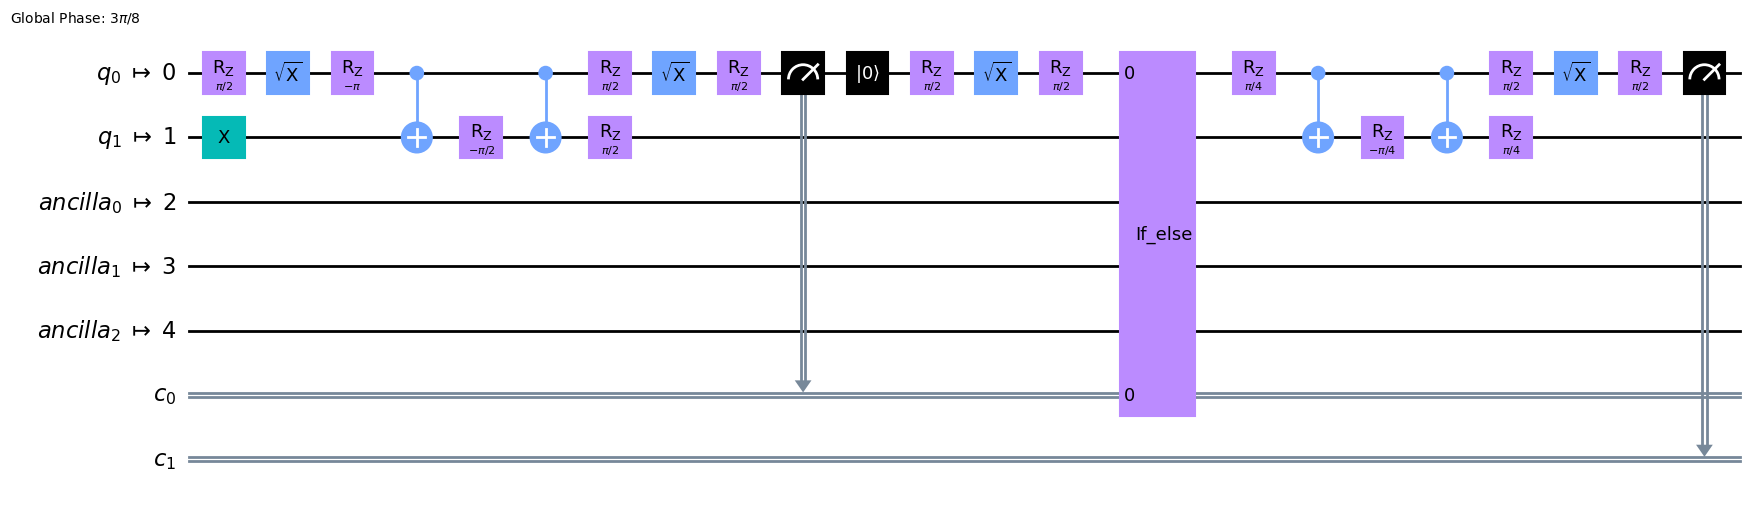

In [24]:
# import the transpile feature
# from the IBM's Qiskit library
from qiskit import transpile


# create the quantum register with two qubits
# for the quantum circuit to implement IPE on the S gate
qr = QuantumRegister(2, "q")

# create a classical register with two bits
# for the quantum circuit to implement IPE on the S gate
cr = ClassicalRegister(2, "c")


# create the quantum circuit with
# the quantum and classical registers
# defined before to implement IPE on the S gate
qc = QuantumCircuit(qr, cr)


# perform the 2nd step of the IPE on the S gate to
# the quantum circuit created before
qc = step_2_circuit(qr, cr)

# create the transpiled quantum circuit
# to implement IPE on the S gate
qc_transpiled = transpile(qc, backend)


# draw the quantum circuit implementing
# an IPE on the S gate
qc_transpiled.draw("mpl")

In [26]:
job = backend.run(qc_transpiled, shots=1000, dynamic=True)
job_id = job.job_id()
print(job_id)

cj8ka0slik6102vtfpq0


In [27]:
retrieve_job = provider.retrieve_job(job_id)
retrieve_job.status()

<JobStatus.QUEUED: 'job is queued'>

In [29]:
""" OPTIONAL
from qiskit.tools.visualization import plot_histogram

counts = retrieve_job.result().get_counts()
plot_histogram(counts)
"""

' OPTIONAL\nfrom qiskit.tools.visualization import plot_histogram\n\ncounts = retrieve_job.result().get_counts()\nplot_histogram(counts)\n'